# Root Locus Tool

Interactive root locus plotting tool for control systems 1:
- Enter a transfer function $ G(s) = \frac{N(s)}{D(s)} $
- Plot the root locus of $ 1 + K G(s) = 0 $ as $K$ varies
- Show poles/zeros, asymptotes & centroid, branch count, and real-axis segments
- Estimate breakaway / break-in points on the real axis
- Optional: highlight $j\omega$ crossings (Routh-like sweep)

> Tip: coefficients are space- or comma-separated, highest power first (e.g. `1 3 2` for $s^2 + 3s + 2$).


What still needs to be done:
- fix the zoom slider, just use Kmax as a slider
- remove Kmin
- Fix the parse error in state space mode
- Maybe add some presets for state space
- fix the double TF visual bug
- Add some more instructions on how to use it

In [1]:

import numpy as np
import matplotlib.pyplot as plt
try:
    from ipywidgets import VBox, HBox, Text, FloatText, IntSlider, Button, Output, Checkbox, Layout, Dropdown, HTML
    from IPython.display import display, clear_output
    _HAS_WIDGETS = True
except Exception:
    # Minimal shims so the notebook executes without ipywidgets installed
    _HAS_WIDGETS = False
    class _Shim:
        def __init__(self, *a, **k): self.value = k.get('value', None)
    class Layout: 
        def __init__(self, **k): pass
    VBox = HBox = Text = FloatText = IntSlider = Button = Output = Checkbox = Dropdown = HTML = _Shim
    def display(*a, **k): pass
    def clear_output(*a, **k): pass

def parse_coeffs(s):
    if isinstance(s, (list, tuple, np.ndarray)):
        return np.array(s, dtype=float)
    s = s.replace(',', ' ').strip()
    if not s:
        return np.array([1.0])
    parts = [p for p in s.split() if p.strip()]
    return np.array([float(p) for p in parts], dtype=float)

def poly_roots(coeffs):
    coeffs = np.trim_zeros(np.array(coeffs, dtype=float), 'f')
    if len(coeffs) == 0:
        return np.array([])
    return np.roots(coeffs)

def poly_add(p, q):
    p = np.array(p, dtype=float); q = np.array(q, dtype=float)
    if len(p) < len(q):
        p = np.pad(p, (len(q)-len(p), 0))
    elif len(q) < len(p):
        q = np.pad(q, (len(p)-len(q), 0))
    return p + q

def poly_scale(p, k):
    return np.array(p, dtype=float) * float(k)

def poly_derivative(p):
    p = np.array(p, dtype=float)
    n = len(p)-1
    return np.array([p[i]*(n-i) for i in range(n)], dtype=float) if n>=0 else np.array([0.0])


In [2]:
class TransferFunction:
    def __init__(self, num, den):
        self.num = np.trim_zeros(parse_coeffs(num), 'f')
        self.den = np.trim_zeros(parse_coeffs(den), 'f')
        if len(self.den)==0:
            self.den = np.array([1.0])
    @property
    def zeros(self):
        return poly_roots(self.num) if len(self.num)>1 else np.array([])
    @property
    def poles(self):
        return poly_roots(self.den)
    @property
    def relative_degree(self):
        return max(0, len(self.den)-len(self.num))
    def characteristic(self, K):
        return poly_add(self.den, poly_scale(self.num, K))

def asymptotes(tf):
    r = tf.relative_degree
    if r <= 0:
        return dict(count=0, angles=[], centroid=np.nan)
    poles = tf.poles; zeros = tf.zeros
    centroid = (np.sum(poles) - np.sum(zeros)) / r if len(zeros) else (np.sum(poles))/r
    centroid = np.real_if_close(centroid).item() if np.isreal(centroid) else np.real(centroid)
    angles = [ (2*k+1)*np.pi/r for k in range(r) ]
    return dict(count=r, angles=angles, centroid=float(np.real(centroid)))

def breakaway_points(tf):
    p = tf.den; q = tf.num
    if len(q)<=1:
        dK_num = poly_derivative(p)
        cand = np.roots(dK_num) if len(dK_num)>1 else np.array([])
    else:
        P = p; Q = q
        Pp = poly_derivative(P); Qp = poly_derivative(Q)
        num1 = np.convolve(Pp, Q)
        num2 = np.convolve(P, Qp)
        dnum = num1 - num2
        cand = np.roots(dnum) if len(dnum)>1 else np.array([])
    rz = np.concatenate([tf.poles, tf.zeros])
    real_brk = []
    for z in cand:
        if np.isclose(np.imag(z), 0.0, atol=1e-6):
            x = float(np.real(z))
            count_right = np.sum(np.real(rz) > x - 1e-9)
            if count_right % 2 == 1:
                real_brk.append(x)
    return np.array(sorted(real_brk))

def jw_crossings(tf, K_grid):
    crossings = []
    for K in K_grid:
        roots = np.roots(tf.characteristic(K))
        close = roots[np.isclose(np.real(roots), 0.0, atol=1e-3)]
        if len(close)>0:
            for r in close:
                crossings.append((K, r))
    return crossings

def root_locus(tf, K_min=0.0, K_max=100.0, nK=500):
    Ks = np.linspace(K_min, K_max, nK)
    loci = []
    for K in Ks:
        loci.append(np.roots(tf.characteristic(K)))
    return Ks, np.array(loci, dtype=complex)


# --- State-space to TF via Leverrier-Faddeev (works without scipy) ---
def ss2tf_leverrier(A, B, C, D):
    A = np.array(A, dtype=float)
    B = np.array(B, dtype=float).reshape(A.shape[0], -1)
    C = np.array(C, dtype=float).reshape(-1, A.shape[0])
    D = np.array(D, dtype=float).reshape(C.shape[0], B.shape[1])
    n = A.shape[0]
    I = np.eye(n)
    # Characteristic polynomial p(s) = s^n + a1 s^{n-1} + ... + an
    # Leverrier recursion
    Bk = I.copy()
    a = []
    for k in range(1, n+1):
        ak = - np.trace(A @ Bk) / k
        a.append(ak)
        Bk = A @ Bk + ak * I
    den = np.array([1.0] + a, dtype=float)  # highest degree first

    # adj(sI - A) = sum_{k=0}^{n-1} s^{n-1-k} Bk_tilde, where
    # B0=I, Bk_tilde from the same recursion we computed: we need all Bk prior to last update
    # Recompute and store sequence B_seq = [B0, B1, ..., B_{n-1}]
    B_seq = [I.copy()]
    Bk = I.copy()
    a_iter = iter(a)
    for k in range(1, n):
        ak = a[k-1]
        Bk = A @ Bk + ak * I
        B_seq.append(Bk.copy())

    # Build numerator polynomials for each input-output pair:
    # N_ij(s) = C_i * [sum s^{n-1-k} B_seq[k]] * B_j  + D_ij * den(s)
    m_out = C.shape[0]; m_in = B.shape[1]
    num = np.zeros((m_out, m_in, len(den)), dtype=float)  # will store full-length (degree n) polys
    # sum s^{n-1-k} Bk means coefficient matrix for s^{n-1-k}
    for i in range(m_out):
        for j in range(m_in):
            # polynomial accumulator of degree n-1 (init zeros)
            coeffs = np.zeros(n, dtype=float)
            for k in range(n):
                # power s^{n-1-k}
                power_idx = k  # maps to coeffs[k]
                mat = B_seq[k]
                scalar = (C[i, :] @ mat @ B[:, j]).item()
                coeffs[power_idx] = scalar
            # Add D*den contribution: numerator_full = coeffs (degree n-1) + D_ij * den (degree n)
            # Align to degree n: prepend 0 to coeffs
            coeffs_full = np.concatenate([[0.0], coeffs])
            coeffs_full += D[i, j] * den
            num[i, j, :] = coeffs_full

    # For SISO, return 1D arrays
    if m_out == 1 and m_in == 1:
        return num[0,0,:], den
    return num, den

def parse_matrix(s):
    """Parse A/B/C/D matrix text. Accepts formats like:
    '1 0; -2 -3'  (rows separated by ';') or JSON-like '[[1,0],[-2,-3]]'.
    """
    s = s.strip()
    if not s:
        return np.zeros((0,0))
    if s.startswith('['):
        import ast
        return np.array(ast.literal_eval(s), dtype=float)
    # semicolon rows
    rows = [r for r in s.split(';') if r.strip()!='']
    mat = [ [float(x) for x in r.replace(',', ' ').split()] for r in rows ]
    return np.array(mat, dtype=float)


# --- Pretty printers ---
def poly_to_latex(coeffs, var='s'):
    coeffs = np.trim_zeros(np.array(coeffs, dtype=float), 'f')
    n = len(coeffs)-1
    if n < 0: 
        return "0"
    terms = []
    for i,c in enumerate(coeffs):
        pow_ = n - i
        if abs(c) < 1e-12: 
            continue
        # sign and magnitude
        sgn = '-' if c < 0 else '+'
        mag = abs(c)
        if pow_ == 0:
            term = f"{mag:.3g}"
        elif pow_ == 1:
            if np.isclose(mag,1.0): term = var
            else: term = f"{mag:.3g}{var}"
        else:
            if np.isclose(mag,1.0): term = f"{var}^{{{pow_}}}"
            else: term = f"{mag:.3g}{var}^{{{pow_}}}"
        terms.append((sgn, term))
    if not terms:
        return "0"
    # first term without leading '+'
    first_sgn, first_term = terms[0]
    out = ('' if first_sgn=='+' else '-') + first_term
    for sgn, term in terms[1:]:
        out += f" {sgn} {term}"
    return out

def mat_to_latex(M):
    M = np.array(M, dtype=float)
    if M.size == 0:
        return r"\begin{bmatrix}\end{bmatrix}"
    rows = [' & '.join(f"{x:.3g}" for x in row) for row in M]
    body = r" \\ ".join(rows)
    return r"\begin{bmatrix}" + body + r"\end{bmatrix}"

In [3]:

def plot_root_locus(tf, Ks, loci, show_asym=True, show_real_segments=True, show_break=True, show_jw=False, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7,6))
    n_branches = loci.shape[1]
    for i in range(n_branches):
        ax.plot(np.real(loci[:,i]), np.imag(loci[:,i]), linewidth=1.5)
    poles, zeros = tf.poles, tf.zeros
    ax.scatter(np.real(poles), np.imag(poles), marker='x', s=80, label='Poles')
    # --- compute plot limits from locus data (trim by percentiles) ---
    xs = np.real(loci).ravel(); ys = np.imag(loci).ravel()
    # percentiles from UI (zoom slider), defaults set on ax
    lo = getattr(ax, '_zoom_lo', 20.0)
    hi = getattr(ax, '_zoom_hi', 80.0)
    lo = max(0.0, min(lo, 49.0)); hi = min(100.0, max(hi, 51.0))
    x_lo, x_hi = np.percentile(xs, [lo, hi])
    y_lo, y_hi = np.percentile(ys, [lo, hi])
    x_min, x_max = float(x_lo), float(x_hi)
    y_min, y_max = float(y_lo), float(y_hi)
    # --- Focus toward poles: use intersection with a padded pole box ---
    if poles.size:
        px0, px1 = float(np.min(np.real(poles))), float(np.max(np.real(poles)))
        py0, py1 = float(np.min(np.imag(poles))), float(np.max(np.imag(poles)))
        pspan_x = max(1e-9, px1 - px0); pspan_y = max(1e-9, py1 - py0)
        # pad poles box so markers are clearly visible
        px0 -= 0.40*pspan_x; px1 += 0.40*pspan_x
        py0 -= 0.40*pspan_y; py1 += 0.40*pspan_y
        # intersection of boxes (keeps view tight around poles)
        ix0 = max(x_min, px0); ix1 = min(x_max, px1)
        iy0 = max(y_min, py0); iy1 = min(y_max, py1)
        if ix1 > ix0 and iy1 > iy0:
            x_min, x_max = ix0, ix1
            y_min, y_max = iy0, iy1
        else:
            # fallback: expand trimmed box a bit toward poles if intersection empty
            x_min = min(x_min, px0); x_max = max(x_max, px1)
            y_min = min(y_min, py0); y_max = max(y_max, py1)
    # also include zeros lightly (no heavy bias)
    if zeros.size:
        zx0, zx1 = float(np.min(np.real(zeros))), float(np.max(np.real(zeros)))
        zy0, zy1 = float(np.min(np.imag(zeros))), float(np.max(np.imag(zeros)))
        x_min = min(x_min, zx0); x_max = max(x_max, zx1)
        y_min = min(y_min, zy0); y_max = max(y_max, zy1)
    # padding + symmetric y-limits for better aspect
    x_span = max(1e-6, x_max - x_min); y_span = max(1e-6, y_max - y_min)
    padx = max(0.05, 0.06 * x_span); pady = max(0.05, 0.08 * y_span)
    # symmetric y around 0 so equal aspect looks nicer
    y_abs = max(abs(y_min), abs(y_max))
    y_low, y_high = -y_abs - pady, y_abs + pady
    # Easing: blend with prior limits if present
    try:
        prev = ax._last_limits
        px0, px1, py0, py1 = prev
        blend = 0.12
        x0 = (1-blend)*(x_min - padx) + blend*px0
        x1 = (1-blend)*(x_max + padx) + blend*px1
        y0 = (1-blend)*y_low + blend*py0
        y1 = (1-blend)*y_high + blend*py1
    except Exception:
        x0, x1, y0, y1 = (x_min - padx, x_max + padx, y_low, y_high)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax._last_limits = (x0, x1, y0, y1)
    if len(tf.num)>1:
        ax.scatter(np.real(zeros), np.imag(zeros), marker='s', s=80, facecolors='none', edgecolors='red', label='Zeros')
    if show_asym:
        a = asymptotes(tf)
        if a['count']>0 and np.isfinite(a['centroid']):
            cx = a['centroid']
            for th in a['angles']:
                L = max(ax.get_xlim()[1]-ax.get_xlim()[0], ax.get_ylim()[1]-ax.get_ylim()[0])
                ax.plot([cx, cx + 0.6*L*np.cos(th)], [0, 0.6*L*np.sin(th)], linestyle='--', linewidth=1, alpha=0.7, clip_on=True)
            ax.axvline(cx, color='k', linestyle=':', linewidth=0.8, alpha=0.4)
            ax.text(cx, 0, f"centroid={cx:.3g}", ha='left', va='bottom', fontsize=9)
    if show_real_segments:
        rz = np.concatenate([poles, zeros])
        xpts = np.sort(np.real(rz[np.isclose(np.imag(rz),0,atol=1e-10)]))
        if len(xpts):
            xs = np.linspace(min(np.min(np.real(loci))-1, xpts.min()-1),
                             max(np.max(np.real(loci))+1, xpts.max()+1), 1000)
            ys = np.zeros_like(xs)
            ax.plot(xs, ys, linestyle='-', linewidth=2, alpha=0.15)
    if show_break:
        brk = breakaway_points(tf)
        first_bp = True
        for x in brk:
            lbl = 'Break point' if first_bp else '_nolegend_'
            ax.scatter([x], [0], s=60, marker='s', label=lbl)
            ax.text(x, 0, f"{x:.3g}", ha='center', va='bottom', fontsize=8)
            first_bp = False
    if show_jw:
        for K, r in jw_crossings(tf, np.linspace(Ks.min(), Ks.max(), 50)):
            ax.scatter([np.real(r)], [np.imag(r)], marker='^', s=60, label='_nolegend_')
            ax.text(np.real(r), np.imag(r), f"K≈{K:.2g}", fontsize=8, ha='left', va='bottom')
    # Axes lines
    ax.axhline(0, color='k', linewidth=0.8)
    ax.axvline(0, color='k', linewidth=0.8)
    # Autoscale with padding to avoid squeezed look
    xr = np.real(loci)
    xi_min, xi_max = np.nanmin(xr), np.nanmax(xr)
    yi = np.imag(loci)
    yi_min, yi_max = np.nanmin(yi), np.nanmax(yi)
    # include poles/zeros in limits
    if len(poles):
        xi_min = min(xi_min, np.min(np.real(poles)))
        xi_max = max(xi_max, np.max(np.real(poles)))
        yi_min = min(yi_min, np.min(np.imag(poles)))
        yi_max = max(yi_max, np.max(np.imag(poles)))
    if len(zeros):
        xi_min = min(xi_min, np.min(np.real(zeros)))
        xi_max = max(xi_max, np.max(np.real(zeros)))
        yi_min = min(yi_min, np.min(np.imag(zeros)))
        yi_max = max(yi_max, np.max(np.imag(zeros)))
    # symmetrical padding
    x_span = xi_max - xi_min if np.isfinite(xi_max - xi_min) else 1.0
    y_span = yi_max - yi_min if np.isfinite(yi_max - yi_min) else 1.0
    pad_x = 0.08 * x_span + 0.5
    pad_y = 0.08 * y_span + 0.5
    ax.set_xlim(xi_min - pad_x, xi_max + pad_x)
    ax.set_ylim(yi_min - pad_y, yi_max + pad_y)
    # Labels and layout
    ax.set_xlabel('Real Axis')
    ax.set_ylabel('Imag Axis')
    ax.set_aspect('equal', adjustable='datalim')
    ax.grid(True, which='both', alpha=0.3)
    try:
        ax.legend(loc='best')
    except Exception:
        pass
    ax.set_title('Root Locus')
    try:
        fig = ax.get_figure()
        fig.set_size_inches(8.0, 6.5)
        fig.tight_layout()
    except Exception:
        pass
    return ax

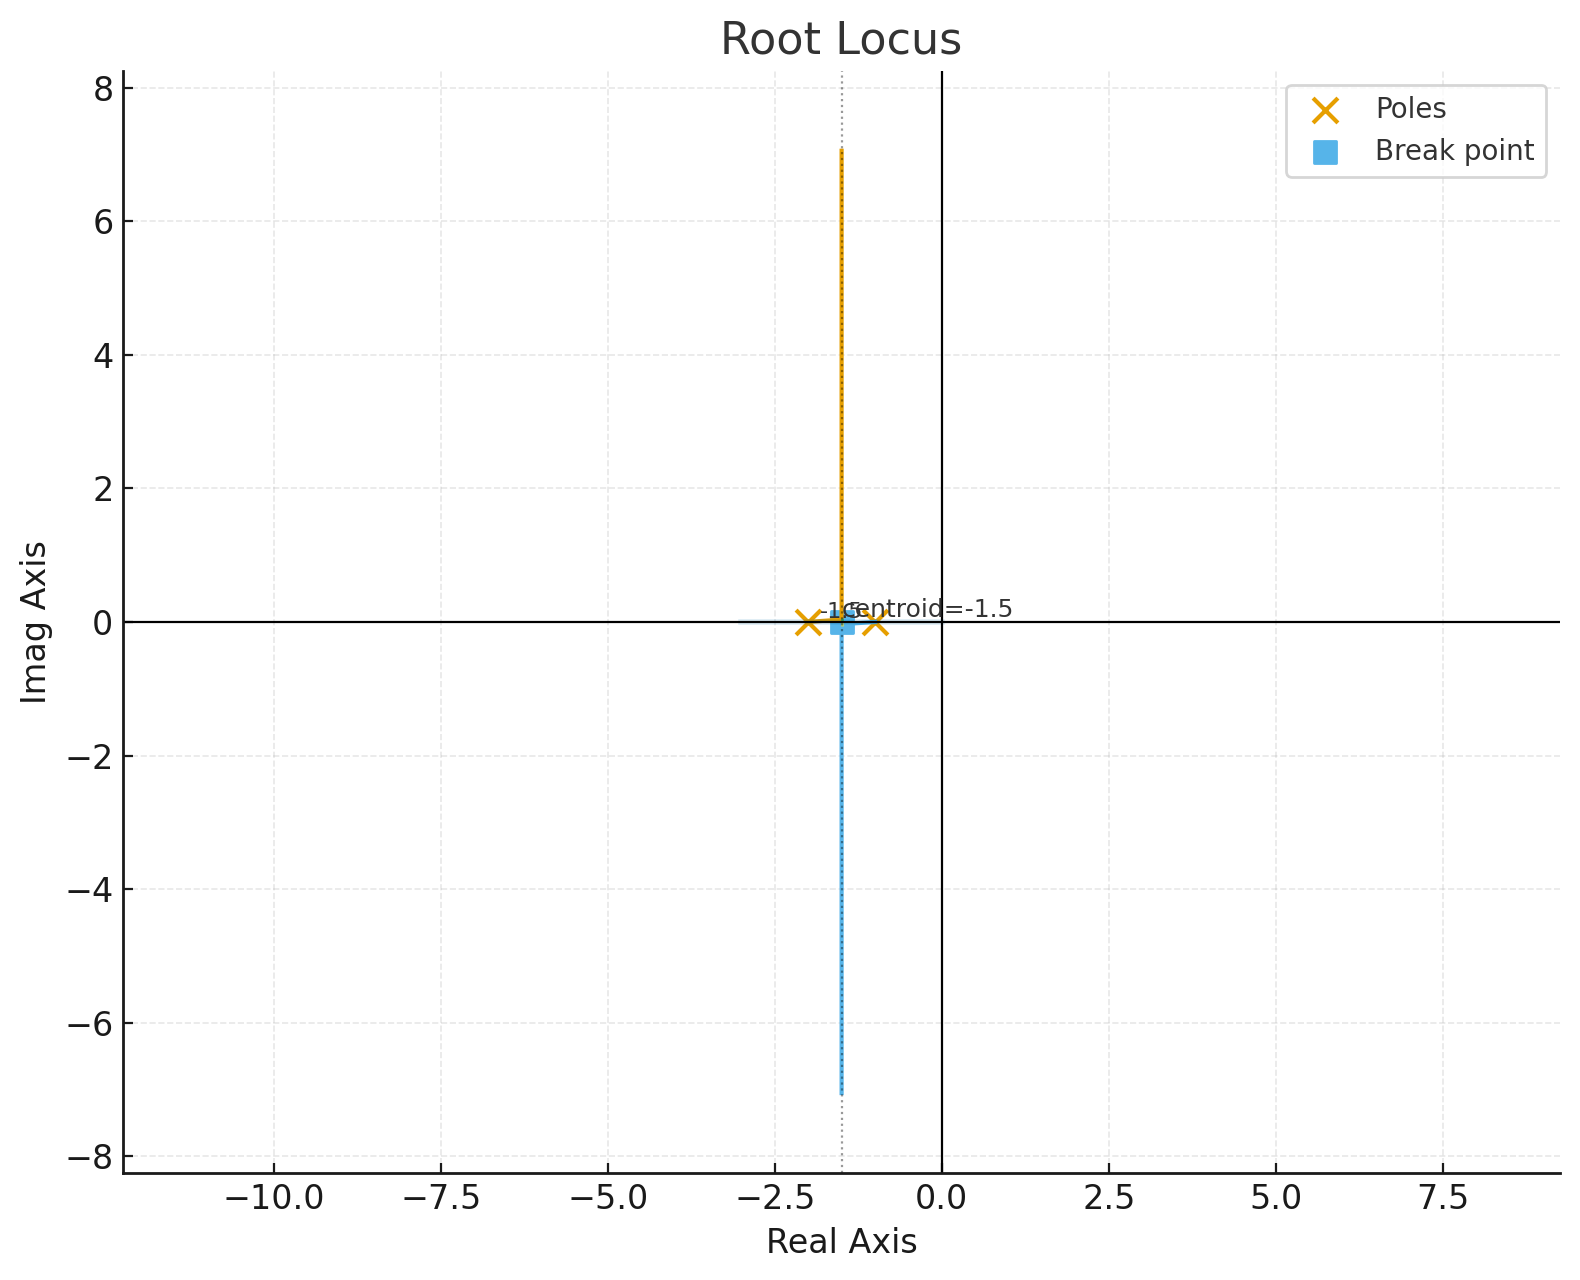

Note: ipywidgets not found. GUI disabled; plotted a demo locus instead.


In [4]:

# --- UI ---

mode = Dropdown(description='Mode', options=['Transfer Function', 'State Space'], value='Transfer Function')
A_in = Text(description='A', value='0 1; -2 -3')  # e.g., '0 1; -2 -3'
B_in = Text(description='B', value='1; 0')
C_in = Text(description='C', value='1 0')
D_in = Text(description='D', value='0')

num_in = Text(description='Numerator', value='1')
den_in = Text(description='Denominator', value='1 3 2')  # (s+1)(s+2)
kmin_in = FloatText(description='K min', value=0.0, layout=Layout(width='150px'))
kmax_in = FloatText(description='K max', value=200.0, layout=Layout(width='150px'))
nk_in   = IntSlider(description='K samples', min=50, max=2000, step=50, value=600, layout=Layout(width='350px'), continuous_update=True)
opt_asym = Checkbox(description='Asymptotes', value=True)
opt_real = Checkbox(description='Real-axis segs', value=True)
opt_break= Checkbox(description='Breakaway', value=True)
opt_jw   = Checkbox(description='jω crossings (approx)', value=False)
zoom_in  = IntSlider(description='Zoom', min=0, max=45, step=1, value=20, layout=Layout(width='320px'))

btn = Button(description='Plot Root Locus', button_style='primary', layout=Layout(display='none'))
out = Output(layout=Layout(border='1px solid #ddd', padding='8px'))

# Presets / menu
examples = {
    "— choose —": None,
    "2nd order, no zeros: (s+1)(s+2)": {"num":"1", "den":"1 3 2", "K":[0,200,600]},
    "3rd order with zero: (s+1)(s+2)(s+4)/(s+3)": {"num":"1 3", "den":"1 7 14 8", "K":[0,300,800]},
    "Integrating plant: 1/(s(s+2))": {"num":"1", "den":"1 2 0", "K":[0,200,600]},
    "Lead-lag: (s+1)(s+2)/(s(s+5))": {"num":"1 3 2", "den":"1 5 0", "K":[0,300,800]}
}
preset = Dropdown(description='Preset', options=list(examples.keys()), value="— choose —")

def apply_preset(change):
    name = change['new']
    if name and examples.get(name):
        ex = examples[name]
        num_in.value = ex["num"]; den_in.value = ex["den"]
        kmin_in.value = ex["K"][0]; kmax_in.value = ex["K"][1]; nk_in.value = ex["K"][2]

if _HAS_WIDGETS:
    preset.observe(apply_preset, names='value')

def update_plot(*_):
    with out:
        clear_output(wait=True)
        try:
            if mode.value == 'Transfer Function':
                tf = TransferFunction(num_in.value, den_in.value)
            else:
                A = parse_matrix(A_in.value); B = parse_matrix(B_in.value); C = parse_matrix(C_in.value); D = parse_matrix(D_in.value if D_in.value.strip() else '0')
                num_tf, den_tf = ss2tf_leverrier(A, B, C, D)
                tf = TransferFunction(num_tf, den_tf)


            # --- Show input representation above the plot ---
            from IPython.display import Math as _Math

            from IPython.display import display as _display, Math as _Math
            if mode.value == 'Transfer Function':
                Nlatex = poly_to_latex(tf.num, 's')
                Dlatex = poly_to_latex(tf.den, 's')
                _display(_Math(r"G(s) = \dfrac{"+Nlatex+r"}{"+Dlatex+r"}"))
            else:
                _display(_Math('\\begin{aligned}' + 'A &= ' + mat_to_latex(A) + '\\ \\' + 'B &= ' + mat_to_latex(B) + '\\ \\' + 'C &= ' + mat_to_latex(C) + '\\ \\' + 'D &= ' + mat_to_latex(D) + '\\end{aligned}'))

                        # --- Show input representation above the plot ---
            if mode.value == 'Transfer Function':
                Nlatex = poly_to_latex(tf.num, 's')
                Dlatex = poly_to_latex(tf.den, 's')
                _display(_Math(r"\displaystyle G(s) = \frac{" + Nlatex + r"}{" + Dlatex + r"}"))
            else:
                ss_latex = (
                    "\\begin{aligned}\n"
                    + "A &= " + mat_to_latex(A) + " \\\\\n"
                    + "B &= " + mat_to_latex(B) + " \\\\\n"
                    + "C &= " + mat_to_latex(C) + " \\\\\n"
                    + "D &= " + mat_to_latex(D) + "\n\\end{aligned}"
                )
                _display(_Math(ss_latex))

            Ks, loci = root_locus(tf, kmin_in.value, kmax_in.value, nk_in.value)
            fig, ax = plt.subplots(figsize=(7.5,6.5))

            # Map zoom slider to percentiles and attach to ax before plotting
            lo = float(zoom_in.value)
            hi = 100.0 - float(zoom_in.value)
            lo = max(0.0, min(lo, 49.0)); hi = min(100.0, max(hi, 51.0))
            ax._zoom_lo = lo; ax._zoom_hi = hi

            plot_root_locus(tf, Ks, loci, opt_asym.value, opt_real.value, opt_break.value, opt_jw.value, ax=ax)

            from IPython.display import display as _display
            _display(fig)
            plt.close(fig)

            az = asymptotes(tf)
            angles_deg = ', '.join(f'{a*180/np.pi:.1f}' for a in az['angles']) if az['angles'] else '—'
            html = f"""            <b>Summary</b><br>
            Poles: {np.round(tf.poles,3)}<br>
            Zeros: {np.round(tf.zeros,3)}<br>
            Branches: {loci.shape[1]} &nbsp; Relative degree: {tf.relative_degree}<br>
            Asymptote count: {az['count']}, centroid: {az['centroid']:.3g}, angles (deg): {angles_deg}
            """
            display(HTML(html))
        except Exception as e:
            print("Error:", e)

if _HAS_WIDGETS:
    for w in (mode, num_in, den_in, A_in, B_in, C_in, D_in, kmin_in, kmax_in, nk_in, opt_asym, opt_real, opt_break, opt_jw, preset, zoom_in):
        w.observe(update_plot, names='value')

ui = VBox([
    HTML("<h3>Root Locus Tool</h3>"),
    mode,
    HTML("<b>Transfer Function: G(s) = N(s)/D(s)</b>"),
    VBox([num_in, den_in]),
    HTML("<b>State Space (SISO):</b> A, B, C, D (rows by ';' or [[...]] syntax)"),
    HBox([A_in, B_in]),
    HBox([C_in, D_in]),
    HBox([kmin_in, kmax_in, nk_in]),
    HBox([opt_asym, opt_real, opt_break, opt_jw, zoom_in], layout=Layout(margin='8px 0')),
    preset,
    out
])

if _HAS_WIDGETS:
    display(ui)
    update_plot()
else:
    # Headless demo to ensure the notebook runs without ipywidgets
    tf = TransferFunction('1', '1 3 2')
    Ks, loci = root_locus(tf, 0, 50, 200)
    fig, ax = plt.subplots(figsize=(6,5))
    # Set a reasonable default zoom if no widgets
    ax._zoom_lo = 20.0; ax._zoom_hi = 80.0
    plot_root_locus(tf, Ks, loci, True, True, True, False, ax=ax)
    from IPython.display import display as _display
    _display(fig)
    plt.close(fig)
    print('Note: ipywidgets not found. GUI disabled; plotted a demo locus instead.')
